# Code for figures in problem a)

In this notebook we do experiments with minimising OLS and Ridge cost functions for the Franke function for different methods and hyperparametres

In [8]:
# IMPORT
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.descent_methods import *

# Import the gradient methods
from Code.utilities import train_test_split, MSELoss_method

# Import the gradient methods
from Code.utilities import OLS_train_analgrad, OLS_train_autograd, ridge_train_analgrad, ridge_train_autograd

# Import tools from the first project 
from Code.project1_tools import feature_matrix_2d, r2_sampling, scale_feature_matrix

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import time as time

In [9]:
# Initialise beta
num_features = 10

# Start with small values
beta0 = {"b" : np.random.random(num_features)*0.1}

# Sample points and split in train and test
num_points = 100
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Scaling etc...
X = feature_matrix_2d(x, y, num_features)
X, means, var = scale_feature_matrix(X)
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, split)

# Squeeze to avoid errors due to shape [100, 1]
y_train, y_test = np.squeeze(y_train), np.squeeze(y_test)

# Number of of minibatch when using batch size eg. 10, this is exact ...
batch_size = 10
m = int(len(y_train) / batch_size) 
epochs = 20

# Define the polynomial fit model
def model(beta, X):
    return jnp.dot(X, beta["b"])

loss_func = MSELoss_method(model)

### Comparing the 4 gradients

1.2738807201385498
10.882804870605469
1.2087795734405518


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18.93890118598938


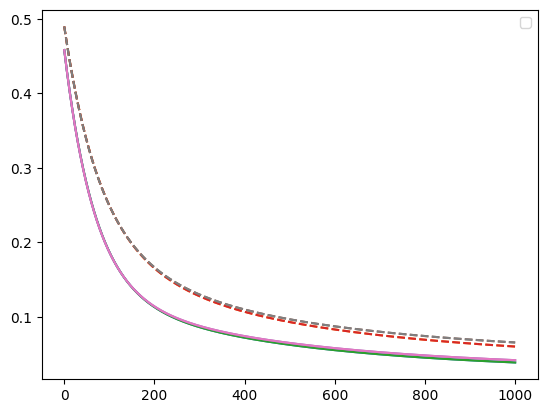

In [10]:
# Initialise beta
n_epochs = 1000


lam=0.1
lr = 0.05



for loss_grad in [OLS_train_analgrad(model), OLS_train_autograd(model), 
                  ridge_train_analgrad(model, lam), ridge_train_autograd(model, lam)]:

    t0 = time.time()

    result_GD = GD(X_train, y_train, X_test, y_test, 
                grad_method=loss_grad, 
                n_epochs=n_epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))

    print(time.time()-t0)

    plt.plot(result_GD["train_loss_list"])
    plt.plot(result_GD["test_loss_list"], linestyle="--")

plt.legend()
plt.show()

See that anal and auto give same results, but automatic takes 10* as much time ---> we use analytic in the following!

Note also that Ridge takes twice as long for auto. This might be because we have 2 terms of jnpsum(jnppower)...

### Comparing the methods for different number of epochs

Final error for GD = 0.11352892220020294
Final error for SGD = 0.02066366747021675
Final error for adagrad = 0.0161016546189785
Final error for RMS prop = 0.010810340754687786
Final error for adam = 0.008057022467255592


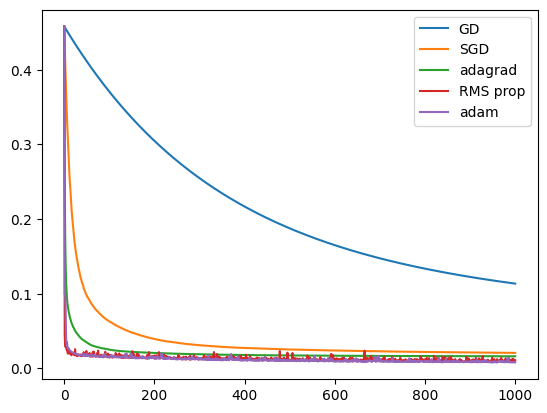

In [20]:
## We compare final train error to see "how far convergence has come"

# Use OLS analytic
loss_grad = OLS_train_analgrad(model)
lr = 0.01

# Max epoch number
n_epochs = 1000

# For methods with n_batches, the default 5 is used!
n_batches = 5

methods_dict_list = [
    {"name"   : "GD",       "method" : GD},
    {"name"   : "SGD",      "method" : SGD},
    {"name"   : "adagrad",  "method" : SGD_adagrad},
    {"name"   : "RMS prop", "method" : SGD_RMS_prop},
    {"name"   : "adam",     "method" : SGD_adam}
]

for method_dict in methods_dict_list:

    method_func = method_dict["method"]
    method_name = method_dict["name"]

    result = method_func(X_train, y_train, X_test, y_test, 
            grad_method=loss_grad, 
            n_epochs=n_epochs, 
            lr=lr,
            beta0=beta0, 
            test_loss_func=(MSELoss_method(model)))
        
    if method_name=="GD": # batch size 1
        plt.plot(result["train_loss_list"][::1], label=method_name)
    else:
        plt.plot(result["train_loss_list"][::n_batches], label=method_name)
    print(f"Final error for {method_name} = {result['train_loss_list'][-1]}")


plt.legend()
plt.show()

In [ ]:
## We compare final train error to see "how far convergence has come"

# Use OLS analytic
loss_grad = OLS_train_analgrad(model)
lr = 0.01

n_epochs_to_test = [5, 10, 15, 20, 50, 100]

# For methods with n_batches, the default 5 is used!

methods_dict_list = [
    {"name"   : "GD",       "method" : GD},
    {"name"   : "SGD",      "method" : GD},
    {"name"   : "adagrad",  "method" : SGD_adagrad},
    {"name"   : "RMS prop", "method" : SGD_RMS_prop},
    {"name"   : "adam",     "method" : SGD_adam}
]

for method_dict in methods_dict_list:

    method_func = method_dict["method"]
    method_name = method_dict["name"]

    final_errors = []

    for n_epochs in n_epochs_to_test:


        result = method_func(X_train, y_train, X_test, y_test, 
                grad_method=loss_grad, 
                n_epochs=n_epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))
        
        final_errors.append(result["train_loss_list"][-1])

    plt.plot(n_epochs_to_test, final_errors, label=method_name)

plt.legend()
plt.show()

In [ ]:
"""
### analysis of results for OLS and RIDGE as function of
- lr
- #mini batches
- #epochs
- algorithm

- lambda for ridge!
    - use seabord ... to show results as function of lr and lam !
"""


'\n### analysis of results for OLS and RIDGE as function of\n- lr\n- #mini batches\n- #epochs\n- algorithm\n\n- lambda for ridge!\n    - use seabord ... to show results as function of lr and lam !\n'

### Seaborn Ridge
Ridge as function of learning rate and lambda

use seabord ... to show results as function of lr and lam !


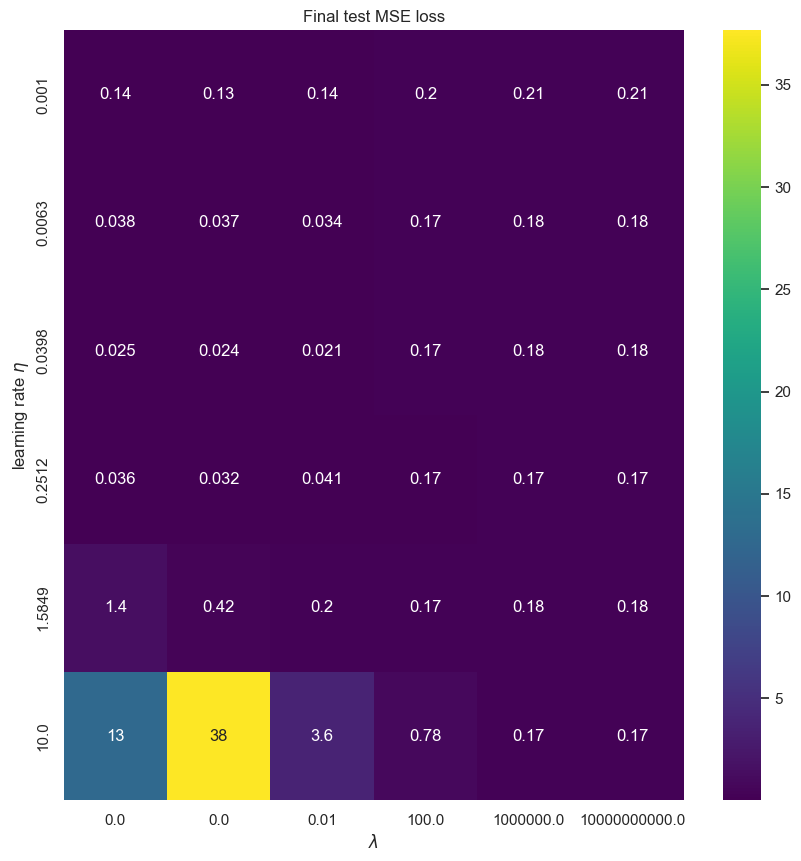

In [ ]:
# ensure the same random numbers appear every time
np.random.seed(0)

# Fixed parametres
epochs = 10

# Values for experiment
lr_vals = np.logspace(-3, 1, 6)
lam_vals = np.logspace(-10, 10, 6)
results = np.zeros((len(lr_vals), len(lam_vals)))

# We juse analytic ridge
train_grad = ridge_train_analgrad

# Perform algorithm for each value
for i, lr in enumerate(lr_vals):
    for j, lam in enumerate(lam_vals):

        # Get gradient function for given lambda
        grad_method = train_grad(model, lam)

        # Perform experiment
        result_GD = SGD_adam(X_train, y_train, X_test, y_test, 
                    grad_method=grad_method, 
                    n_epochs=epochs, 
                    n_batches=5,
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=loss_func)

        # Append the final error from training
        results[i, j] = result_GD["test_loss_list"][-1]


# Make plot
sns.set()
fig, ax = plt.subplots(figsize = (10, 10))
df = pd.DataFrame(results, index=lr_vals, columns=lam_vals)
sns.heatmap(df, annot=True, ax=ax, cmap="viridis",                  
            xticklabels=df.columns.values.round(4),
            yticklabels=df.index.values.round(4))
ax.set_title("Final test MSE loss")
ax.set_ylabel("learning rate $\eta$")
ax.set_xlabel("$\lambda$")

plt.show()